#  Final project: the "1C" competition
This challenge serves as final project for the "How to win a data science competition" Coursera course.

In this competition you will work with a challenging time-series dataset consisting of daily sales data, kindly provided by one of the largest Russian software firms - 1C Company. 

We are asking you to predict total sales for every product and store in the next month. By solving this competition you will be able to apply and enhance your data science skills.

## File descriptions
* transactions.csv - the training set. Daily historical data from January 2013 to October 2015.
* test.csv - the test set. You need to forecast the sales for these shops and products for November 2015.
* sample_submission.csv - a sample submission file in the correct format.
* items.csv - supplemental information about the items/products.
* item_categories.csv  - supplemental information about the items categories.
* shops.csv- supplemental information about the shops.

## Data fields
* ID - an Id that represents a (Shop, Item) tuple within the test set
* shop_id - unique identifier of a shop
* item_id - unique identifier of a product
* item_category_id - unique identifier of item category
* item_cnt_day - number of products sold. You are predicting a monthly amount of this measure
* item_price - current price of an item
* date - date in format dd/mm/yyyy
* date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
* item_name - name of item
* shop_name - name of shop
* item_category_name - name of item category

## Import Library

In [1]:
import numpy as np
from numpy import absolute, mean, std, arange
import pandas as pd 
import sklearn
import scipy.sparse 
import lightgbm as lgb
from lightgbm import LGBMRegressor
import os
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import xgboost
from xgboost import XGBRegressor, plot_importance
from catboost import Pool, CatBoostRegressor
from scipy.stats import uniform
from itertools import product
import pickle
import time
import math
import re
import gc

from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingClassifier
from sklearn.metrics import r2_score
from tqdm import tqdm_notebook
from mlxtend.preprocessing import minmax_scaling
from itertools import product

from vecstack import stacking
from bayes_opt import BayesianOptimization

pd.set_option('display.max_rows', 600)
pd.set_option('display.max_columns', 50)

import warnings
warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", None)

SEED = 123
start_0 = time.time()
%matplotlib inline

In [2]:
for p in [np, pd, scipy, sklearn, lgb]:
    print (p.__name__, p.__version__)

numpy 1.20.1
pandas 1.2.4
scipy 1.6.2
sklearn 0.24.1
lightgbm 3.1.1


## Load Data

In [3]:
DATA_FOLDER = "./"

#the training set. Daily historical data from January 2013 to October 2015.
transactions    = pd.read_csv(os.path.join(DATA_FOLDER, 'sales_train.csv.gz'))

#the test set. You need to forecast the sales for these shops and products for November 2015.
test            =   pd.read_csv(os.path.join(DATA_FOLDER, 'test.csv.gz')) #test data

#supplemental information about the items/products.
items           =   pd.read_csv(os.path.join(DATA_FOLDER, 'items.csv')) #item id and its category id

#supplemental information about the items categories.
item_categories =   pd.read_csv(os.path.join(DATA_FOLDER, 'item_categories.csv')) #item category name

#supplemental information about the shops.
shops           =   pd.read_csv(os.path.join(DATA_FOLDER, 'shops.csv')) #shop name

#a sample submission file in the correct format.
#sample_submission = pd.read_csv(os.path.join(DATA_FOLDER, 'sample_submission.csv.gz')) #sample_submission

## Exploratory Data Analysis

#### Sales Train (Intution: Understand the item_price, item_cnt_day, revenue for the seasonal trends on the transactions)

In [4]:
print("Shape of transactions: "+ str(transactions.shape))
transactions.head()

Shape of transactions: (2935849, 6)


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


### Feature preprocessing and generation with respect to the final Target

Convert Date Feature to day, month , year and gernerate the revenue feature

In [5]:
# Generate date feature
newcols = transactions["date"].str.split(".", expand=True)
ls = ["day", "month", "year"]
for i in range(len(ls)):
    transactions.insert(i, ls[i], newcols[i])
transactions['weekday'] = pd.to_datetime(transactions['date'], format = '%d.%m.%Y').dt.dayofweek
transactions['date'] = pd.to_datetime(transactions['date'], format='%d.%m.%Y')

# Add revenues
transactions["revenue"] = transactions["item_price"]*transactions["item_cnt_day"]

In [6]:
print("Shape of transactions: "+ str(transactions.shape))
transactions.head()

Shape of transactions: (2935849, 11)


,day,month,year,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,weekday,revenue
0,02,01,2013,2013-01-02,0,59,22154,999.00,1.0,2,999.00
1,03,01,2013,2013-01-03,0,25,2552,899.00,1.0,3,899.00
2,05,01,2013,2013-01-05,0,25,2552,899.00,-1.0,5,-899.00
3,06,01,2013,2013-01-06,0,25,2554,1709.05,1.0,6,1709.05
4,15,01,2013,2013-01-15,0,25,2555,1099.00,1.0,1,1099.00


In [7]:
transactions.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,weekday,revenue
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00,3.365686e+00,1.157732e+03
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00,1.996795e+00,5.683604e+03
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01,0.000000e+00,-6.897000e+04
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00,2.000000e+00,2.490000e+02
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00,4.000000e+00,4.490000e+02
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00,5.000000e+00,1.078200e+03
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03,6.000000e+00,1.829990e+06


#### Revenue seasonal trends Analysis

<AxesSubplot:xlabel='date_block_num'>

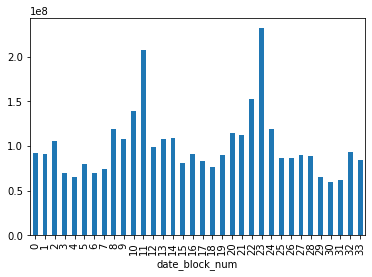

In [8]:
# revenue pick at Christmas and low in summer
transactions.groupby("date_block_num")["revenue"].sum().plot.bar()

<AxesSubplot:xlabel='weekday'>

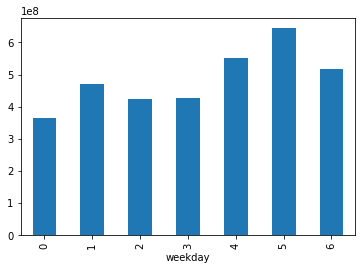

In [9]:
# revenue difference between weekday vs. weekends
transactions.groupby("weekday")["revenue"].sum().plot.bar()

<AxesSubplot:xlabel='shop_id'>

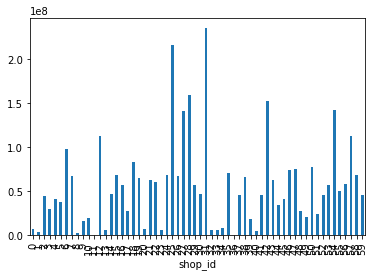

In [10]:
# revenue difference @ differernt shop 
transactions.groupby("shop_id")["revenue"].sum().plot.bar()

<AxesSubplot:xlabel='date_block_num'>

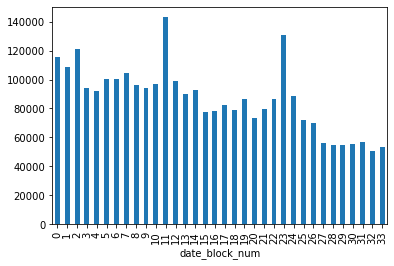

In [11]:
# the transactions are decreasing but the price is going up
# so the revenue is still increasing
transactions.groupby("date_block_num").count().revenue.plot.bar()

<AxesSubplot:xlabel='date_block_num'>

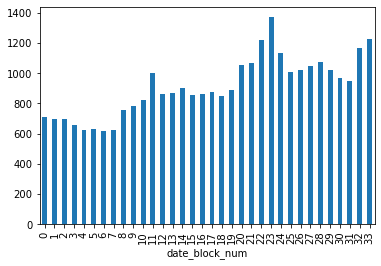

In [12]:
transactions.groupby("date_block_num").item_price.mean().plot.bar()

<AxesSubplot:xlabel='date_block_num'>

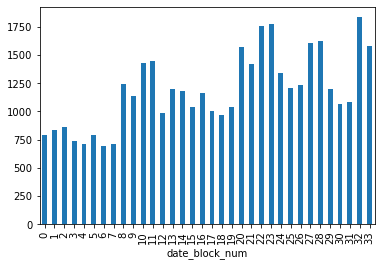

In [13]:
transactions.groupby("date_block_num").revenue.mean().plot.bar()

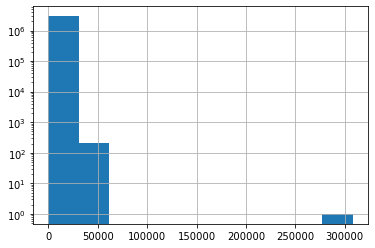

In [14]:
transactions.item_price.hist()
plt.yscale('log', nonposy='clip')
plt.show()

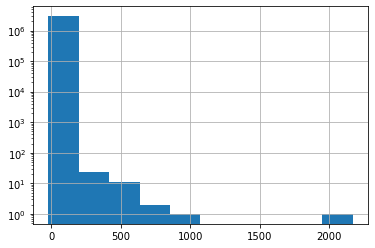

In [15]:
transactions.item_cnt_day.hist()
plt.yscale('log', nonposy='clip')
plt.show()

Text(0, 0.5, 'item_cnt_day')

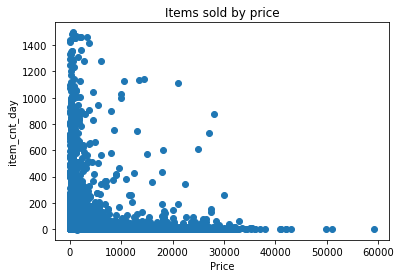

In [16]:
x_price = transactions[transactions['item_price'] < 60000] # drop outliers
x_price = x_price.groupby('item_price').agg({'item_cnt_day': 'sum'})
x_price = x_price[x_price['item_cnt_day'].values < 1500] # drop outliers
plt.title('Items sold by price')
plt.scatter(x_price.index, x_price['item_cnt_day'])
plt.xlabel('Price')
plt.ylabel('item_cnt_day')

#### Item Price (Intution: Understand the Max of the item price and unique item price)

In [17]:
# item price
transactions.item_price.value_counts()
print("Number of prices:",transactions.item_price.nunique())

Number of prices: 19993


#### Item category

In [18]:
print(items.shape)
items.head()

(22170, 3)


,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


<AxesSubplot:xlabel='item_category_id'>

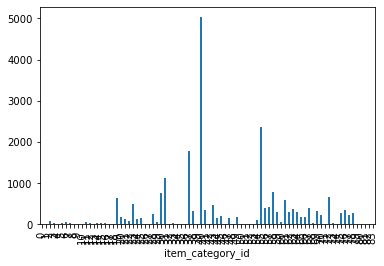

In [19]:
# item_category revenue
items.groupby("item_category_id").item_id.count().plot(kind="bar")

In [20]:
print(item_categories.shape)
item_categories.head()

(84, 2)


,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


#### Features from text are extracted - Not need for the special preprocessing for text are utilized (TF-IDF, stemming, levenshtening...) HERE

In [21]:
# Translate the item category name and find meta category, subtype
item_categories['meta_category'] = item_categories['item_category_name'].apply(lambda x: x.split('-')[0])
item_categories['subtype'] = item_categories['item_category_name'].apply(lambda x: x.split('-')) \
                                                                  .map(lambda x:x[1].strip() if len(x)>1 else x[0].strip())
item_categories.head(10)

,item_category_name,item_category_id,meta_category,subtype
0,PC - Гарнитуры/Наушники,0,PC,Гарнитуры/Наушники
1,Аксессуары - PS2,1,Аксессуары,PS2
2,Аксессуары - PS3,2,Аксессуары,PS3
3,Аксессуары - PS4,3,Аксессуары,PS4
4,Аксессуары - PSP,4,Аксессуары,PSP
5,Аксессуары - PSVita,5,Аксессуары,PSVita
6,Аксессуары - XBOX 360,6,Аксессуары,XBOX 360
7,Аксессуары - XBOX ONE,7,Аксессуары,XBOX ONE
8,Билеты (Цифра),8,Билеты (Цифра),Билеты (Цифра)
9,Доставка товара,9,Доставка товара,Доставка товара


In [22]:
print(item_categories.meta_category.value_counts())

Книги                                13
Подарки                              12
Игровые консоли                       8
Игры                                  8
Аксессуары                            7
Программы                             6
Музыка                                6
Кино                                  5
Игры PC                               4
Карты оплаты                          4
Карты оплаты (Кино, Музыка, Игры)     1
Элементы питания                      1
PC                                    1
Чистые носители (шпиль)               1
Служебные                             1
Игры Android                          1
Служебные                             1
Доставка товара                       1
Чистые носители (штучные)             1
Билеты (Цифра)                        1
Игры MAC                              1
Name: meta_category, dtype: int64


#### Label Encoding:
##### New Featature generated - Make item meta categories, subtypes

In [23]:
# Label encoding
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
item_categories["meta_category_code"] = labelencoder.fit_transform(item_categories["meta_category"])
item_categories["subtype_code"] = labelencoder.fit_transform(item_categories["subtype"])
item_categories = item_categories.drop(["item_category_name", "meta_category", "subtype"], axis=1)

In [24]:
item_categories.head(5)

,item_category_id,meta_category_code,subtype_code
0,0,0,29
1,1,1,9
2,2,1,10
3,3,1,11
4,4,1,13


#### Shop Analysis

In [25]:
print(shops.shape)
print(shops.nunique())

(60, 2)
shop_name    60
shop_id      60
dtype: int64


In [26]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [27]:
shops["city"] = shops["shop_name"].apply(lambda x: x.split()[0])
df_cities = shops['city'].value_counts().rename_axis('city').reset_index(name='counts')

In [28]:
cities = list(df_cities['city'])
cities

['Москва',
 'Воронеж',
 'РостовНаДону',
 'Тюмень',
 'Красноярск',
 'Якутск',
 'Уфа',
 'Казань',
 'Самара',
 'Жуковский',
 'Н.Новгород',
 '!Якутск',
 'СПб',
 'Новосибирск',
 'Выездная',
 'Балашиха',
 'Омск',
 'Вологда',
 'Томск',
 'Калуга',
 'Интернет-магазин',
 'Курск',
 'Ярославль',
 'Цифровой',
 'Коломна',
 'Мытищи',
 'Химки',
 'Адыгея',
 'Волжский',
 'Сергиев',
 'Чехов',
 'Сургут']

In [29]:
for city in cities:
    print(city)
    print(shops[shops.city == city])

Москва
                             shop_name  shop_id    city
20                 Москва "Распродажа"       20  Москва
21              Москва МТРЦ "Афи Молл"       21  Москва
22                  Москва Магазин С21       22  Москва
23    Москва ТК "Буденовский" (пав.А2)       23  Москва
24    Москва ТК "Буденовский" (пав.К7)       24  Москва
25                 Москва ТРК "Атриум"       25  Москва
26         Москва ТЦ "Ареал" (Беляево)       26  Москва
27      Москва ТЦ "МЕГА Белая Дача II"       27  Москва
28     Москва ТЦ "МЕГА Теплый Стан" II       28  Москва
29  Москва ТЦ "Новый век" (Новокосино)       29  Москва
30              Москва ТЦ "Перловский"       30  Москва
31             Москва ТЦ "Семеновский"       31  Москва
32          Москва ТЦ "Серебряный Дом"       32  Москва
Воронеж
                      shop_name  shop_id     city
6    Воронеж (Плехановская, 13)        6  Воронеж
7        Воронеж ТРЦ "Максимир"        7  Воронеж
8  Воронеж ТРЦ Сити-Парк "Град"        8  Воронеж
Р

In [30]:
# Check the shop start day and last day
shop_life=pd.DataFrame(columns=["shop_id","Start", "Stop"])
shop_life["shop_id"]=np.arange(60)
shop_life["Start"]=transactions.groupby("shop_id")["date_block_num"].min()
shop_life["Stop"]=transactions.groupby("shop_id")["date_block_num"].max()
shop_life.merge(shops, how="left").drop("shop_name",axis=1)
shop_life.head(10)

,shop_id,Start,Stop
0,0,0,1
1,1,0,1
2,2,0,33
3,3,0,33
4,4,0,33
5,5,1,33
6,6,0,33
7,7,0,33
8,8,0,3
9,9,9,33


##### Fix the duplicated shop_id

In [31]:
# shop 10 and 11 are the same
# shop 1 and 58 are the same
# shop 0 and 57 are the same
transactions.loc[transactions["shop_id"]==11,"shop_id"]=10
transactions.loc[transactions["shop_id"]==1,"shop_id"]=58
transactions.loc[transactions["shop_id"]==0,"shop_id"]=57

In [32]:
#Check whether all the shops are both in train and test sets
test_list = list(sorted(test["shop_id"].unique()))
out_of_list = [i for i in list(range(60)) if i not in test_list]
print(out_of_list)

shop_not_active = shop_life[shop_life["Stop"]<33].shop_id
out_of_list_active = [i for i in out_of_list if i not in shop_not_active]
print(out_of_list_active)

[0, 1, 8, 9, 11, 13, 17, 20, 23, 27, 29, 30, 32, 33, 40, 43, 51, 54]
[9, 20]


#### Label Encoding:
##### Make shop meta categories (city)

In [33]:
# Label encoding
shops["city_code"] = labelencoder.fit_transform(shops["city"])
shops = shops.drop(["shop_name", "city"], axis=1)
shops.head(5)

,shop_id,city_code
0,0,0
1,1,0
2,2,1
3,3,2
4,4,3


#### Merge into transactions

In [34]:
transactions = pd.merge(transactions, items, how='left', on='item_id')
transactions = pd.merge(transactions, item_categories, how='left', on='item_category_id')
transactions = pd.merge(transactions, shops, how='left', on='shop_id')

In [35]:
transactions.drop("item_name",axis=1,inplace=True)
transactions.head()

,day,month,year,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,weekday,revenue,item_category_id,meta_category_code,subtype_code,city_code
0,02,01,2013,2013-01-02,0,59,22154,999.00,1.0,2,999.00,37,11,1,31
1,03,01,2013,2013-01-03,0,25,2552,899.00,1.0,3,899.00,58,13,27,14
2,05,01,2013,2013-01-05,0,25,2552,899.00,-1.0,5,-899.00,58,13,27,14
3,06,01,2013,2013-01-06,0,25,2554,1709.05,1.0,6,1709.05,58,13,27,14
4,15,01,2013,2013-01-15,0,25,2555,1099.00,1.0,1,1099.00,56,13,3,14


In [36]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(transactions.head())

  day month  year       date  date_block_num  shop_id  item_id  item_price  \
0  02    01  2013 2013-01-02               0       59    22154      999.00   
1  03    01  2013 2013-01-03               0       25     2552      899.00   
2  05    01  2013 2013-01-05               0       25     2552      899.00   
3  06    01  2013 2013-01-06               0       25     2554     1709.05   
4  15    01  2013 2013-01-15               0       25     2555     1099.00   

   item_cnt_day  weekday  revenue  item_category_id  meta_category_code  \
0           1.0        2   999.00                37                  11   
1           1.0        3   899.00                58                  13   
2          -1.0        5  -899.00                58                  13   
3           1.0        6  1709.05                58                  13   
4           1.0        1  1099.00                56                  13   

   subtype_code  city_code  
0             1         31  
1            27       

In [37]:
print("transactions dimensions: {}".format(transactions.shape))

transactions dimensions: (2935849, 15)


In [38]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(transactions.dtypes)

day                           object
month                         object
year                          object
date                  datetime64[ns]
date_block_num                 int64
shop_id                        int64
item_id                        int64
item_price                   float64
item_cnt_day                 float64
weekday                        int64
revenue                      float64
item_category_id               int64
meta_category_code             int64
subtype_code                   int64
city_code                      int64
dtype: object


In [39]:
 # Select columns to change data type
date_cols = ['day', 'month', 'year']
cat_cols = ['shop_id', 'item_id', 'item_category_id','meta_category_code', 'subtype_code', 'city_code']
# Change Type
transactions[date_cols] = transactions[date_cols].astype(np.int64)
transactions[cat_cols] = transactions[cat_cols].astype(np.int16)

In [40]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(transactions.dtypes)

day                            int64
month                          int64
year                           int64
date                  datetime64[ns]
date_block_num                 int64
shop_id                        int16
item_id                        int16
item_price                   float64
item_cnt_day                 float64
weekday                        int64
revenue                      float64
item_category_id               int16
meta_category_code             int16
subtype_code                   int16
city_code                      int16
dtype: object


In [41]:
columns = transactions.columns
percent_missing = transactions.isnull().sum() * 100 / len(transactions)
missing_value_df = pd.DataFrame({'column_name': columns,
                                 'percent_missing': percent_missing})
missing_value_df.sort_values('percent_missing', inplace=True)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(missing_value_df["percent_missing"])

day                   0.0
month                 0.0
year                  0.0
date                  0.0
date_block_num        0.0
shop_id               0.0
item_id               0.0
item_price            0.0
item_cnt_day          0.0
weekday               0.0
revenue               0.0
item_category_id      0.0
meta_category_code    0.0
subtype_code          0.0
city_code             0.0
Name: percent_missing, dtype: float64


In [42]:
cols = missing_value_df[missing_value_df.percent_missing > 0].iloc[:,0]
cols = list(cols.values.flatten())
cols

[]

In [43]:
df_none_unique = transactions.nunique()
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df_none_unique)

day                      31
month                    12
year                      3
date                   1034
date_block_num           34
shop_id                  57
item_id               21807
item_price            19993
item_cnt_day            198
weekday                   7
revenue               24771
item_category_id         84
meta_category_code       21
subtype_code             65
city_code                31
dtype: int64


In [44]:
# List all columns with only one unique value
cols = [c for c in transactions.columns if len(transactions[c].unique()) < 2]
 
for i in cols:
    print(i, transactions[i].nunique())

<AxesSubplot:xlabel='date,date'>

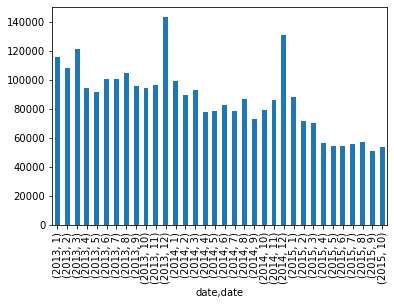

In [45]:
transactions.date.groupby([transactions.date.dt.year, transactions.date.dt.month]).count().plot(kind="bar")

### Univariate Analysis — Histogram and Bar Chart

In [46]:
# List all columns with only two unique value
cols = [c for c in transactions.columns if len(transactions[c].unique()) == 2]
cols

[]

In [47]:
numeric_var = [key for key in dict(transactions.dtypes)
                   if dict(transactions.dtypes)[key]
                       in ['float64','int64','int32']] # Numeric Variable
print(numeric_var)

['day', 'month', 'year', 'date_block_num', 'item_price', 'item_cnt_day', 'weekday', 'revenue']


In [48]:
df_numeric_var = transactions[numeric_var]
df_numeric_var.head()

,day,month,year,date_block_num,item_price,item_cnt_day,weekday,revenue
0,2,1,2013,0,999.00,1.0,2,999.00
1,3,1,2013,0,899.00,1.0,3,899.00
2,5,1,2013,0,899.00,-1.0,5,-899.00
3,6,1,2013,0,1709.05,1.0,6,1709.05
4,15,1,2013,0,1099.00,1.0,1,1099.00


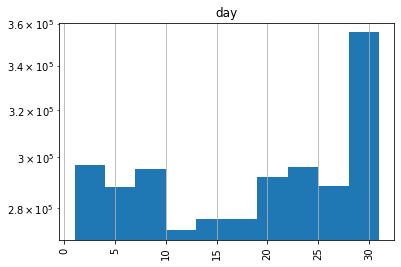

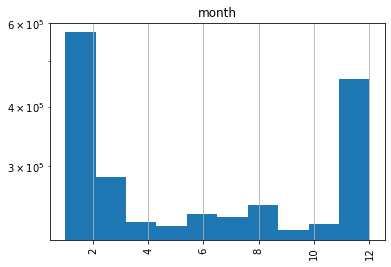

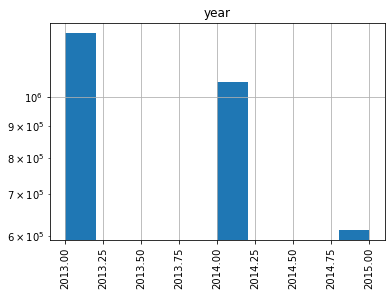

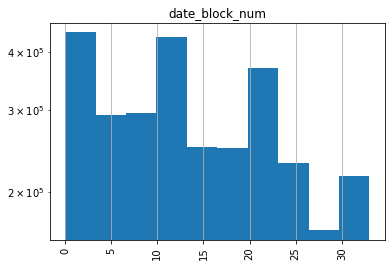

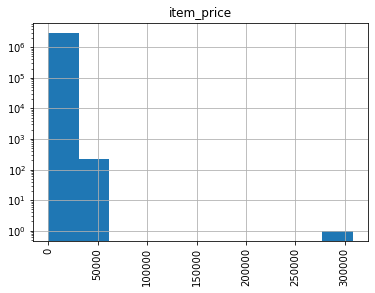

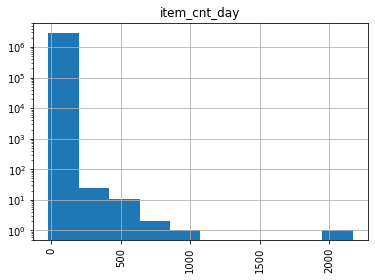

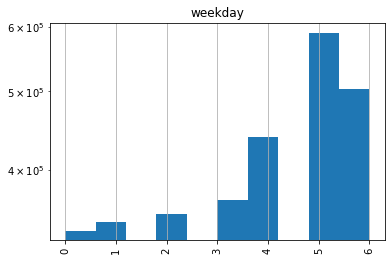

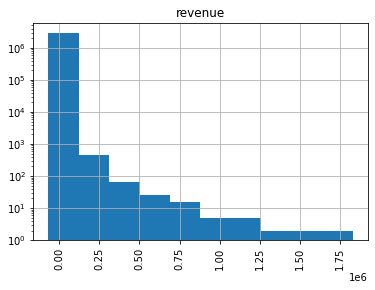

In [49]:
%matplotlib inline
import matplotlib.pyplot as plt
 
for i in range(0,len(numeric_var)):
    df_numeric_var.hist(column=numeric_var[i])
    plt.xticks(rotation='vertical')
    plt.yscale('log', nonposy='clip')
    plt.show()

#### Min Max Scale for Numeric Var

In [50]:
# Min Max Scale
from mlxtend.preprocessing import minmax_scaling
df_numeric_var_scaled = minmax_scaling(df_numeric_var, columns = df_numeric_var.columns.values)

#### Correlation Analysis Heatmap

<AxesSubplot:>

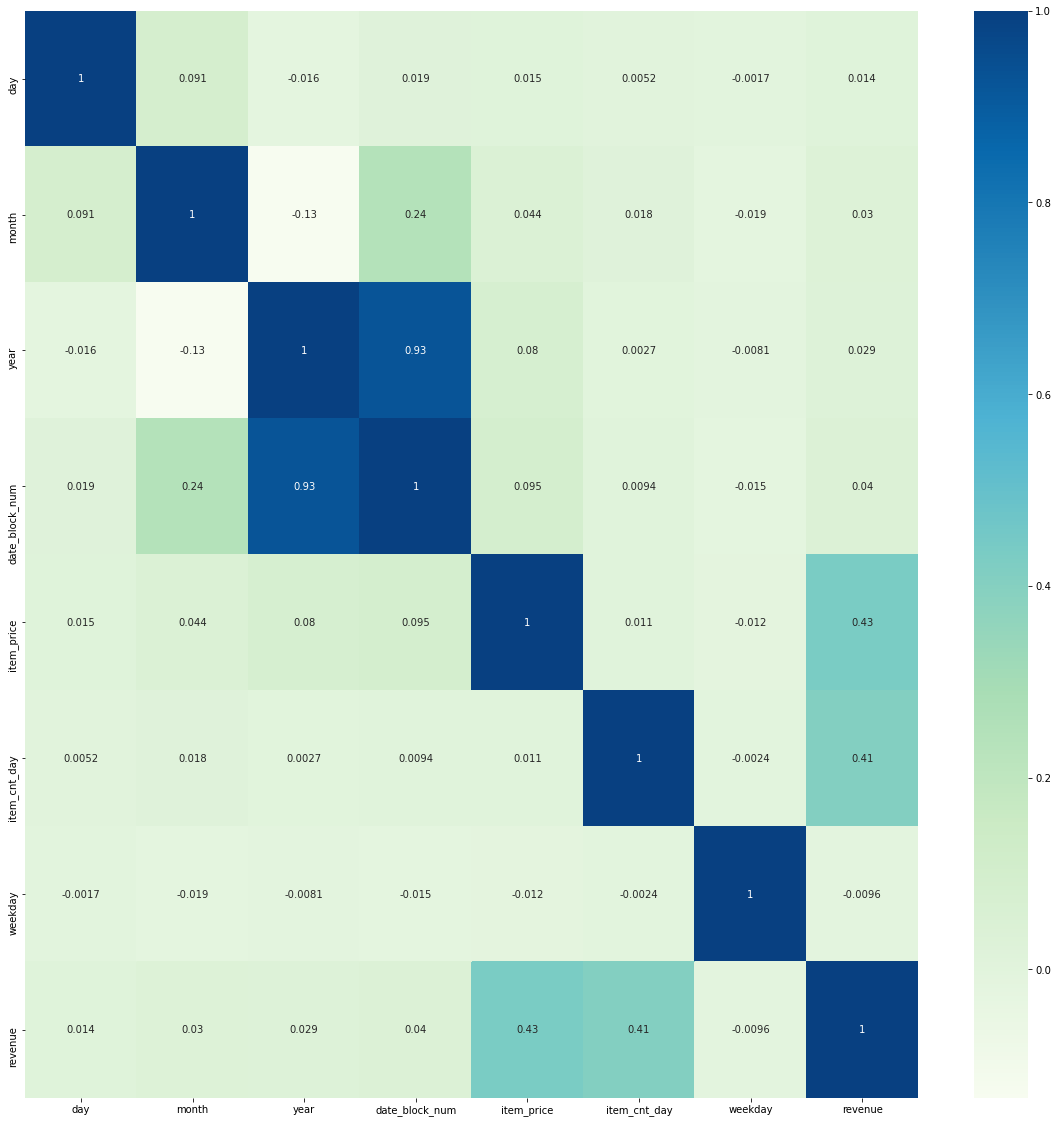

In [51]:
plt.figure(figsize = (20,20))
correlation = df_numeric_var_scaled.corr()
sns.heatmap(correlation, cmap ="GnBu", annot = True)

In [52]:
cat_var = [key for key in dict(transactions.dtypes)
             if dict(transactions.dtypes)[key] in ['int16'] ] # Categorical Varible
print(cat_var)

['shop_id', 'item_id', 'item_category_id', 'meta_category_code', 'subtype_code', 'city_code']


In [53]:
df_cat_var = transactions[cat_var]
df_cat_var.head()

,shop_id,item_id,item_category_id,meta_category_code,subtype_code,city_code
0,59,22154,37,11,1,31
1,25,2552,58,13,27,14
2,25,2552,58,13,27,14
3,25,2554,58,13,27,14
4,25,2555,56,13,3,14


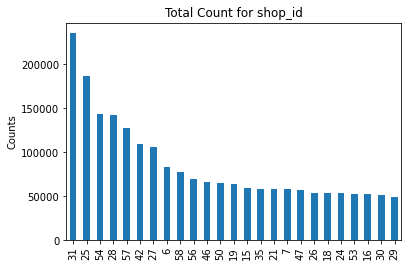

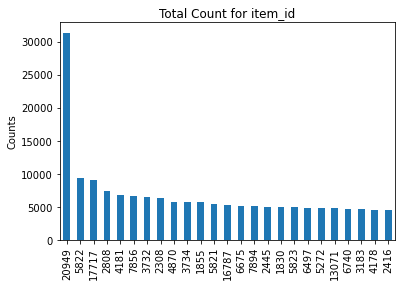

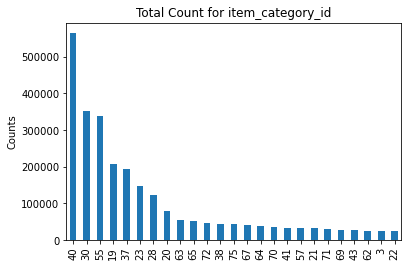

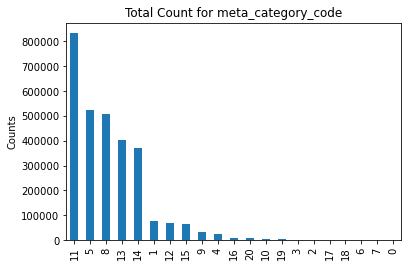

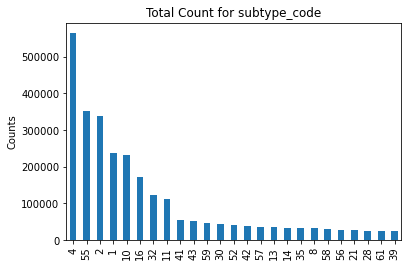

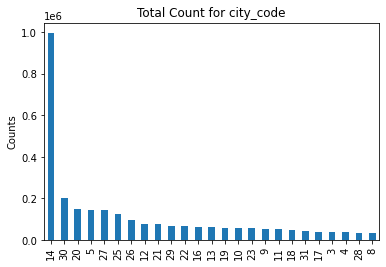

In [54]:
%matplotlib inline
from matplotlib.pyplot import figure
for i in df_cat_var.columns:
    df_cat_var[i].value_counts().nlargest(25).plot.bar(ylim=0)
    plt.ylabel('Counts')
    plt.title('Total Count for {}'.format(i))
    plt.xticks(rotation='vertical')
    plt.show()

In [55]:
print(test.shape)
test.head()

(214200, 3)


,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [56]:
print(test.item_id.value_counts())

2049     42
6743     42
13266    42
21342    42
17244    42
         ..
7338     42
1193     42
3240     42
13359    42
2047     42
Name: item_id, Length: 5100, dtype: int64


In [57]:
print(test.shop_id.value_counts())

2     5100
47    5100
37    5100
38    5100
39    5100
41    5100
42    5100
44    5100
45    5100
46    5100
48    5100
3     5100
49    5100
50    5100
52    5100
53    5100
55    5100
56    5100
57    5100
58    5100
36    5100
35    5100
34    5100
31    5100
4     5100
5     5100
6     5100
7     5100
10    5100
12    5100
14    5100
15    5100
16    5100
18    5100
19    5100
21    5100
22    5100
24    5100
25    5100
26    5100
28    5100
59    5100
Name: shop_id, dtype: int64


In [58]:
def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df

## Data Preprocessing

### Feature preprocessing and generation with respect to models

#### Make new training data based on monthly item_cnt each shop/item pair

In [59]:
# Remove outliers
transactions = transactions[transactions.item_price<100000]
transactions = transactions[transactions.item_cnt_day<1001]

In [60]:
# Create "grid" with columns
index_cols = ['shop_id', 'item_id', 'date_block_num']

# For every month we create a grid from all shops/items combinations from that month
grid = [] 
for block_num in transactions['date_block_num'].unique():
    cur_shops = transactions.loc[transactions['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = transactions.loc[transactions['date_block_num'] == block_num, 'item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))

# Turn the grid into a dataframe
grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)

# Groupby data to get shop-item-month aggregates
gb = transactions.groupby(index_cols,as_index=False).agg({'item_cnt_day': 'sum'})
gb = gb.rename(columns={'item_cnt_day': 'target'})

# Join it to the grid
data = pd.merge(grid, gb, how='left', on=index_cols).fillna(0)

# Same as above but with shop-month aggregates
#gb = transactions.groupby(['shop_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':'sum'})
#gb = gb.rename(columns={'item_cnt_day': 'target_shop'})
#data = pd.merge(data, gb, how='left', on=['shop_id', 'date_block_num']).fillna(0)

# Same as above but with item-month aggregates
#gb = transactions.groupby(['item_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':'sum'})
#gb = gb.rename(columns={'item_cnt_day': 'target_item'})
#data = pd.merge(data, gb, how='left', on=['item_id', 'date_block_num']).fillna(0)

# Downcast dtypes from 64 to 32 bit to save memory
data = downcast_dtypes(data)
del grid, gb 
gc.collect();

In [61]:
target_mean = data['target'].mean()

In [62]:
data.head(5)

,shop_id,item_id,date_block_num,target
0,59,22154,0,1.0
1,59,2552,0,0.0
2,59,2554,0,0.0
3,59,2555,0,0.0
4,59,2564,0,0.0


In [63]:
data.describe()

,shop_id,item_id,date_block_num,target
count,1.091380e+07,1.091380e+07,1.091380e+07,1.091380e+07
mean,3.135673e+01,1.130929e+04,1.497336e+01,3.340756e-01
std,1.732796e+01,6.209982e+03,9.495635e+00,3.329528e+00
min,2.000000e+00,0.000000e+00,0.000000e+00,-2.200000e+01
25%,1.600000e+01,5.976000e+03,7.000000e+00,0.000000e+00
50%,3.000000e+01,1.139100e+04,1.400000e+01,0.000000e+00
75%,4.700000e+01,1.660500e+04,2.300000e+01,0.000000e+00
max,5.900000e+01,2.216900e+04,3.300000e+01,1.644000e+03


In [64]:
data.shape

(10913804, 4)

In [65]:
# Merge test into data
test["date_block_num"] = 34
all_data = pd.concat([data, test], ignore_index=True, keys=index_cols)
all_data.fillna(0, inplace=True) # 34 month

In [66]:
all_data.head()

,shop_id,item_id,date_block_num,target,ID
0,59,22154,0,1.0,0.0
1,59,2552,0,0.0,0.0
2,59,2554,0,0.0,0.0
3,59,2555,0,0.0,0.0
4,59,2564,0,0.0,0.0


In [67]:
all_data.describe()

,shop_id,item_id,date_block_num,target,ID
count,1.112800e+07,1.112800e+07,1.112800e+07,1.112800e+07,1.112800e+07
mean,3.136224e+01,1.130371e+04,1.533960e+01,3.276451e-01,2.061530e+03
std,1.733254e+01,6.210934e+03,9.760412e+00,3.297457e+00,1.703338e+04
min,2.000000e+00,0.000000e+00,0.000000e+00,-2.200000e+01,0.000000e+00
25%,1.600000e+01,5.947000e+03,7.000000e+00,0.000000e+00,0.000000e+00
50%,3.100000e+01,1.138800e+04,1.500000e+01,0.000000e+00,0.000000e+00
75%,4.700000e+01,1.659200e+04,2.300000e+01,0.000000e+00,0.000000e+00
max,5.900000e+01,2.216900e+04,3.400000e+01,1.644000e+03,2.141990e+05


In [68]:
all_data.pop('ID')

0                0.0
1                0.0
2                0.0
3                0.0
4                0.0
              ...   
11127999    214195.0
11128000    214196.0
11128001    214197.0
11128002    214198.0
11128003    214199.0
Name: ID, Length: 11128004, dtype: float64

In [69]:
all_data.head()

,shop_id,item_id,date_block_num,target
0,59,22154,0,1.0
1,59,2552,0,0.0
2,59,2554,0,0.0
3,59,2555,0,0.0
4,59,2564,0,0.0


#### Generate time lag features 1

In [70]:
%%time
# List of columns that we will use to create lags
cols_to_rename = list(all_data.columns.difference(index_cols)) 

shift_range = [1, 2, 3]

for month_shift in tqdm_notebook(shift_range):
    train_shift = all_data[index_cols + cols_to_rename].copy()
    
    train_shift['date_block_num'] = train_shift['date_block_num'] + month_shift
    
    foo = lambda x: '{}_lag_{}'.format(x, month_shift) if x in cols_to_rename else x
    train_shift = train_shift.rename(columns=foo)

    all_data = pd.merge(all_data, train_shift, on=index_cols, how='left').fillna(0)

del train_shift

# Don't use old data from year 2013
all_data = all_data[all_data['date_block_num'] >= 12] 

# List of all lagged features
fit_cols = [col for col in all_data.columns if col[-1] in [str(item) for item in shift_range]] 
# We will drop these at fitting stage
to_drop_cols = list(set(list(all_data.columns)) - (set(fit_cols)|set(index_cols))) + ['date_block_num'] 

# Category for each item
all_data = pd.merge(all_data, shops, on=['shop_id'], how='left')
all_data = pd.merge(all_data, items, on=['item_id'], how='left')
all_data = pd.merge(all_data, item_categories, on=['item_category_id'], how='left')
all_data.pop('item_name')
all_data = downcast_dtypes(all_data)
gc.collect();

  0%|          | 0/3 [00:00<?, ?it/s]

CPU times: user 23.8 s, sys: 6.96 s, total: 30.7 s
Wall time: 30.6 s


26

In [71]:
all_data.head()

,shop_id,item_id,date_block_num,target,target_lag_1,target_lag_2,target_lag_3,city_code,item_category_id,meta_category_code,subtype_code
0,54,10297,12,4.0,3.0,0.0,0.0,27,37,11,1
1,54,10296,12,3.0,0.0,0.0,0.0,27,38,11,1
2,54,10298,12,14.0,21.0,119.0,7.0,27,40,11,4
3,54,10300,12,3.0,1.0,31.0,0.0,27,37,11,1
4,54,10284,12,1.0,0.0,0.0,0.0,27,57,13,8


In [72]:
all_data.columns

Index(['shop_id', 'item_id', 'date_block_num', 'target', 'target_lag_1',
       'target_lag_2', 'target_lag_3', 'city_code', 'item_category_id',
       'meta_category_code', 'subtype_code'],
      dtype='object')

#### Generate Expanding mean encoding features

In [73]:
# expand mean encoding sales by item_id
cumsum = all_data.groupby('item_id')['target'].cumsum() - all_data['target']
cumcnt = all_data.groupby('item_id').cumcount()
all_data['item_target_enc'] = cumsum/cumcnt
#target_mean = data['target'].mean()
all_data['item_target_enc'].fillna(target_mean, inplace=True)
encoded_feature = all_data['item_target_enc'].values

corr = np.corrcoef(all_data['target'].values, encoded_feature)[0][1]
print(corr)
all_data.head()

0.48459109075646895


,shop_id,item_id,date_block_num,target,target_lag_1,target_lag_2,target_lag_3,city_code,item_category_id,meta_category_code,subtype_code,item_target_enc
0,54,10297,12,4.0,3.0,0.0,0.0,27,37,11,1,0.334076
1,54,10296,12,3.0,0.0,0.0,0.0,27,38,11,1,0.334076
2,54,10298,12,14.0,21.0,119.0,7.0,27,40,11,4,0.334076
3,54,10300,12,3.0,1.0,31.0,0.0,27,37,11,1,0.334076
4,54,10284,12,1.0,0.0,0.0,0.0,27,57,13,8,0.334076


In [74]:
# expand mean encoding sales by shop_id
cumsum = all_data.groupby('shop_id')['target'].cumsum() - all_data['target']
cumcnt = all_data.groupby('shop_id').cumcount()
all_data['shop_target_enc'] = cumsum/cumcnt
#target_mean = data['target'].mean()
all_data['shop_target_enc'].fillna(target_mean, inplace=True)
encoded_feature = all_data['shop_target_enc'].values

corr = np.corrcoef(all_data['target'].values, encoded_feature)[0][1]
print(corr)

0.06940498150081716


In [75]:
# expand mean encoding sales by item_category_id
cumsum = all_data.groupby('item_category_id')['target'].cumsum() - all_data['target']
cumcnt = all_data.groupby('item_category_id').cumcount()
all_data['item_category_target_enc'] = cumsum/cumcnt
#target_mean = data['target'].mean()
all_data['item_category_target_enc'].fillna(target_mean, inplace=True)
encoded_feature = all_data['item_category_target_enc'].values

corr = np.corrcoef(all_data['target'].values, encoded_feature)[0][1]
print(corr)

0.4192922811112685


In [76]:
# expand mean encoding sales by city_code
cumsum = all_data.groupby('city_code')['target'].cumsum() - all_data['target']
cumcnt = all_data.groupby('city_code').cumcount()
all_data['city_code_target_enc'] = cumsum/cumcnt
#target_mean = data['target'].mean()
all_data['city_code_target_enc'].fillna(target_mean, inplace=True)
encoded_feature = all_data['city_code_target_enc'].values

corr = np.corrcoef(all_data['target'].values, encoded_feature)[0][1]
print(corr)

0.0492714577452287


In [77]:
# expand mean encoding sales by meta_category_code
cumsum = all_data.groupby('meta_category_code')['target'].cumsum() - all_data['target']
cumcnt = all_data.groupby('meta_category_code').cumcount()
all_data['meta_category_code_target_enc'] = cumsum/cumcnt
#target_mean = data['target'].mean()
all_data['meta_category_code_target_enc'].fillna(target_mean, inplace=True)
encoded_feature = all_data['meta_category_code_target_enc'].values

corr = np.corrcoef(all_data['target'].values, encoded_feature)[0][1]
print(corr)

0.08319541649012686


In [78]:
# expand mean encoding sales by subtype_code
cumsum = all_data.groupby('subtype_code')['target'].cumsum() - all_data['target']
cumcnt = all_data.groupby('subtype_code').cumcount()
all_data['subtype_code_target_enc'] = cumsum/cumcnt
#target_mean = data['target'].mean()
all_data['subtype_code_target_enc'].fillna(target_mean, inplace=True)
encoded_feature = all_data['subtype_code_target_enc'].values

corr = np.corrcoef(all_data['target'].values, encoded_feature)[0][1]
print(corr)

0.41890465430446194


In [79]:
all_data.head()

,shop_id,item_id,date_block_num,target,target_lag_1,target_lag_2,target_lag_3,city_code,item_category_id,meta_category_code,subtype_code,item_target_enc,shop_target_enc,item_category_target_enc,city_code_target_enc,meta_category_code_target_enc,subtype_code_target_enc
0,54,10297,12,4.0,3.0,0.0,0.0,27,37,11,1,0.334076,0.334076,0.334076,0.334076,0.334076,0.334076
1,54,10296,12,3.0,0.0,0.0,0.0,27,38,11,1,0.334076,4.000000,0.334076,4.000000,4.000000,4.000000
2,54,10298,12,14.0,21.0,119.0,7.0,27,40,11,4,0.334076,3.500000,0.334076,3.500000,3.500000,0.334076
3,54,10300,12,3.0,1.0,31.0,0.0,27,37,11,1,0.334076,7.000000,4.000000,7.000000,7.000000,3.500000
4,54,10284,12,1.0,0.0,0.0,0.0,27,57,13,8,0.334076,6.000000,0.334076,6.000000,0.334076,0.334076


#### From Advice 2
The most important step at reproducing this score is correctly aggregating daily data and constructing monthly sales data frame. You need to get lagged values, fill NaNs with zeros and clip the values into [0,20] range. 

Generating features like this is a necessary basis for more complex models. Also, if you decide to fit some model, don't forget to clip the target into [0,20] range, it makes a big difference.

#### Generate lags features

In [80]:
# Make lags features
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

In [81]:
print(all_data[all_data['target_lag_1'] > 0.0].head())

   shop_id  item_id  date_block_num  target  target_lag_1  target_lag_2  \
0       54    10297              12     4.0           3.0           0.0   
2       54    10298              12    14.0          21.0         119.0   
3       54    10300              12     3.0           1.0          31.0   
5       54    10292              12     9.0           8.0          16.0   
6       54    10109              12     2.0           1.0           0.0   

   target_lag_3  city_code  item_category_id  meta_category_code  \
0           0.0         27                37                  11   
2           7.0         27                40                  11   
3           0.0         27                37                  11   
5          15.0         27                40                  11   
6           0.0         27                40                  11   

   subtype_code  item_target_enc  shop_target_enc  item_category_target_enc  \
0             1         0.334076         0.334076            

##### Generate lag mean encoded features

In [82]:
# Make lag encoded features
def encoded(matrix, cols, name, lags):
    a = matrix.copy()
    group = a.groupby(cols).agg({'target': ['mean']})
    group.columns = [name]
    group.reset_index(inplace=True)

    a = pd.merge(a, group, on=cols, how='left')
    a[name] = a[name].astype(np.float32)
    a = lag_feature(a, lags, name)
    a.drop([name], axis=1, inplace=True)
    return a

In [83]:
%%time
# Make lag encoded features
all_data_1 = encoded(all_data, ['date_block_num'], 'date_avg_item_cnt', [1])
all_data_1 = encoded(all_data_1, ['date_block_num', 'item_id'], 'date_item_avg_item_cnt', [1,3,6])
all_data_1 = encoded(all_data_1, ['date_block_num', 'shop_id'], 'date_shop_avg_item_cnt', [1,3,6])
all_data_1 = encoded(all_data_1, ['date_block_num', 'item_category_id'], 'date_category_avg_item_cnt', [1])
all_data_1 = encoded(all_data_1, ['date_block_num', 'shop_id', 'item_category_id'], 'date_shop_category_avg_item_cnt', [1])
all_data_1 = encoded(all_data_1, ['date_block_num', 'shop_id', 'meta_category_code'], 'date_shop_meta_category_avg_item_cnt', [1])
all_data_1 = encoded(all_data_1, ['date_block_num', 'shop_id', 'subtype_code'], 'date_shop_subtype_avg_item_cnt', [1])
all_data_1 = encoded(all_data_1, ['date_block_num', 'city_code'], 'date_city_avg_item_cnt', [1])
all_data_1 = encoded(all_data_1, ['date_block_num', 'item_id', 'city_code'], 'date_item_city_avg_item_cnt', [1])
all_data_1 = encoded(all_data_1, ['date_block_num', 'meta_category_code'], 'date_meta_category_avg_item_cnt', [1])
all_data_1 = encoded(all_data_1, ['date_block_num', 'subtype_code'], 'date_subtype_avg_item_cnt', [1])

CPU times: user 1min 41s, sys: 45.8 s, total: 2min 27s
Wall time: 2min 28s


In [84]:
all_data_1.head()

,shop_id,item_id,date_block_num,target,target_lag_1,target_lag_2,target_lag_3,city_code,item_category_id,meta_category_code,subtype_code,item_target_enc,shop_target_enc,item_category_target_enc,city_code_target_enc,meta_category_code_target_enc,subtype_code_target_enc,date_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_3,date_item_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_6,date_category_avg_item_cnt_lag_1,date_shop_category_avg_item_cnt_lag_1,date_shop_meta_category_avg_item_cnt_lag_1,date_shop_subtype_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_1,date_meta_category_avg_item_cnt_lag_1,date_subtype_avg_item_cnt_lag_1
0,54,10297,12,4.0,3.0,0.0,0.0,27,37,11,1,0.334076,0.334076,0.334076,0.334076,0.334076,0.334076,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,54,10296,12,3.0,0.0,0.0,0.0,27,38,11,1,0.334076,4.000000,0.334076,4.000000,4.000000,4.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,54,10298,12,14.0,21.0,119.0,7.0,27,40,11,4,0.334076,3.500000,0.334076,3.500000,3.500000,0.334076,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,54,10300,12,3.0,1.0,31.0,0.0,27,37,11,1,0.334076,7.000000,4.000000,7.000000,7.000000,3.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,54,10284,12,1.0,0.0,0.0,0.0,27,57,13,8,0.334076,6.000000,0.334076,6.000000,0.334076,0.334076,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [85]:
%%time
# Make lag encoded features for delta item price
group = transactions.groupby(['item_id']).agg({'item_price': ['mean']})
group.columns = ['item_avg_item_price']
group.reset_index(inplace=True)

all_data_1 = pd.merge(all_data_1, group, on=['item_id'], how='left')
all_data_1['item_avg_item_price'] = all_data_1['item_avg_item_price'].astype(np.float32)

group = transactions.groupby(['date_block_num','item_id']).agg({'item_price': ['mean']})
group.columns = ['date_item_avg_item_price']
group.reset_index(inplace=True)

all_data_1 = pd.merge(all_data_1, group, on=['date_block_num','item_id'], how='left')
all_data_1['date_item_avg_item_price'] = all_data_1['date_item_avg_item_price'].astype(np.float32)

lags = [1,3,6]
all_data_1 = lag_feature(all_data_1, lags, 'date_item_avg_item_price')

for i in lags:
    all_data_1['delta_price_lag_'+str(i)] = (all_data_1['date_item_avg_item_price_lag_'+str(i)] - all_data_1['item_avg_item_price']) / all_data_1['item_avg_item_price']

def select_lag(row):
    for i in lags:
        if row['delta_price_lag_'+str(i)]:
            return row['delta_price_lag_'+str(i)]
    return 0
    
all_data_1['delta_price_lag'] = all_data_1.apply(select_lag, axis=1)
all_data_1['delta_price_lag'] = all_data_1['delta_price_lag'].astype(np.float32)
all_data_1['delta_price_lag'].fillna(0, inplace=True)

CPU times: user 1min 36s, sys: 8.11 s, total: 1min 44s
Wall time: 1min 45s


In [86]:
fetures_to_drop = ['item_avg_item_price', 'date_item_avg_item_price']
for i in lags:
    fetures_to_drop += ['date_item_avg_item_price_lag_'+str(i)]
    fetures_to_drop += ['delta_price_lag_'+str(i)]

all_data_1.drop(fetures_to_drop, axis=1, inplace=True)

In [87]:
# Lags are set 12, so remove data where date_block_num > 11
all_data_2 = all_data_1[all_data_1['date_block_num']>11]

# Fill nan
for col in all_data_2.columns:
    all_data_2[col].fillna(0, inplace=True)         

all_data_2['target'] = (all_data_2['target']
                                .fillna(0)
                                .clip(0,20) # NB clip target here
                                .astype(np.float64))

In [88]:
# Add its month and days in that month
all_data_2['month'] = all_data_2['date_block_num'] % 12
all_data_2['month'] = all_data_2['month'].astype(np.int16)
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
all_data_2['days'] = all_data_2['month'].map(days).astype(np.int16)
all_data_2.tail(10)

,shop_id,item_id,date_block_num,target,target_lag_1,target_lag_2,target_lag_3,city_code,item_category_id,meta_category_code,subtype_code,item_target_enc,shop_target_enc,item_category_target_enc,city_code_target_enc,meta_category_code_target_enc,subtype_code_target_enc,date_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_3,date_item_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_6,date_category_avg_item_cnt_lag_1,date_shop_category_avg_item_cnt_lag_1,date_shop_meta_category_avg_item_cnt_lag_1,date_shop_subtype_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_1,date_meta_category_avg_item_cnt_lag_1,date_subtype_avg_item_cnt_lag_1,delta_price_lag,month,days
6639284,45,3280,34,0.0,0.0,0.0,0.0,21,55,13,2,0.162037,0.158580,0.217792,0.164355,0.166381,0.217792,0.289232,0.022727,0.071429,0.159091,0.129688,0.138998,0.144236,0.197015,0.126866,0.089269,0.126866,0.1368,0.0,0.147069,0.197015,0.170655,10,30
6639285,45,4393,34,0.0,0.0,0.0,0.0,21,22,5,14,0.146042,0.158579,0.331638,0.164355,0.630570,0.298638,0.289232,0.022727,0.071429,0.113636,0.129688,0.138998,0.144236,0.228788,0.133333,0.280859,0.135135,0.1368,0.0,0.532932,0.214373,-0.597287,10,30
6639286,45,4352,34,0.0,0.0,0.0,0.0,21,22,5,14,0.333333,0.158578,0.331629,0.164354,0.630569,0.298633,0.289232,0.045455,0.238095,0.022727,0.129688,0.138998,0.144236,0.228788,0.133333,0.280859,0.135135,0.1368,0.0,0.532932,0.214373,-0.181685,10,30
6639287,45,18049,34,0.0,0.0,0.0,0.0,21,70,14,57,0.501272,0.158577,0.385743,0.164354,0.389787,0.385743,0.289232,0.090909,0.285714,1.227273,0.129688,0.138998,0.144236,0.365127,0.139344,0.112999,0.139344,0.1368,0.0,0.313354,0.365127,-0.079477,10,30
6639288,45,18027,34,0.0,0.0,0.0,0.0,21,70,14,57,0.246094,0.158576,0.385738,0.164353,0.389787,0.385738,0.289232,0.068182,0.214286,0.000000,0.129688,0.138998,0.000000,0.365127,0.139344,0.112999,0.139344,0.1368,0.0,0.313354,0.365127,-0.106417,10,30
6639289,45,18454,34,0.0,1.0,0.0,0.0,21,55,13,2,0.957407,0.158574,0.217792,0.164353,0.166380,0.217792,0.289232,0.045455,0.071429,0.590909,0.129688,0.138998,0.144236,0.197015,0.126866,0.089269,0.126866,0.1368,0.5,0.147069,0.197015,-0.475305,10,30
6639290,45,16188,34,0.0,0.0,0.0,0.0,21,64,14,42,0.031250,0.158573,0.279734,0.164352,0.389787,0.279734,0.289232,0.022727,0.000000,0.000000,0.129688,0.000000,0.000000,0.155691,0.094488,0.112999,0.094488,0.1368,0.0,0.313354,0.155691,0.081167,10,30
6639291,45,15757,34,0.0,0.0,0.0,0.0,21,55,13,2,0.201852,0.158572,0.217791,0.164351,0.166380,0.217791,0.289232,0.113636,0.095238,0.250000,0.129688,0.138998,0.144236,0.197015,0.126866,0.089269,0.126866,0.1368,0.0,0.147069,0.197015,0.155905,10,30
6639292,45,19648,34,0.0,0.0,0.0,0.0,21,40,11,4,0.103704,0.158571,0.238070,0.164351,0.203409,0.238070,0.289232,0.045455,0.166667,0.090909,0.129688,0.138998,0.144236,0.221504,0.083756,0.097021,0.083756,0.1368,0.0,0.226283,0.221504,-0.091709,10,30
6639293,45,969,34,0.0,0.0,0.0,0.0,21,37,11,1,0.361045,0.158570,0.161380,0.164350,0.203409,0.162434,0.289232,0.068182,0.023810,0.068182,0.129688,0.138998,0.144236,0.262950,0.128205,0.097021,0.126338,0.1368,0.5,0.226283,0.245474,-0.605811,10,30


In [89]:
all_data_2.to_pickle('data.pkl')

## Training Model

In [90]:
alldfs = [var for var in dir() if isinstance(eval(var), pd.core.frame.DataFrame)]
print(alldfs)

['_', '_18', '_20', '_21', '_24', '_26', '_30', '_33', '_35', '_4', '_48', '_53', '_55', '_6', '_62', '_63', '_66', '_67', '_69', '_7', '_71', '_73', '_79', '_84', '_88', '__', '___', 'all_data', 'all_data_1', 'all_data_2', 'correlation', 'data', 'df_cat_var', 'df_cities', 'df_numeric_var', 'df_numeric_var_scaled', 'group', 'item_categories', 'items', 'missing_value_df', 'newcols', 'shop_life', 'shops', 'test', 'transactions', 'x_price']


In [91]:
for i in dir():
    if isinstance(globals()[i], pd.DataFrame):
        del globals()[i]

gc.collect()

133

#### Load Data

In [92]:
DATA_FOLDER = "./"

data = pd.read_pickle('data.pkl')
test = pd.read_csv(os.path.join(DATA_FOLDER, 'test.csv.gz')) #test data

In [93]:
data.columns

Index(['shop_id', 'item_id', 'date_block_num', 'target', 'target_lag_1',
       'target_lag_2', 'target_lag_3', 'city_code', 'item_category_id',
       'meta_category_code', 'subtype_code', 'item_target_enc',
       'shop_target_enc', 'item_category_target_enc', 'city_code_target_enc',
       'meta_category_code_target_enc', 'subtype_code_target_enc',
       'date_avg_item_cnt_lag_1', 'date_item_avg_item_cnt_lag_1',
       'date_item_avg_item_cnt_lag_3', 'date_item_avg_item_cnt_lag_6',
       'date_shop_avg_item_cnt_lag_1', 'date_shop_avg_item_cnt_lag_3',
       'date_shop_avg_item_cnt_lag_6', 'date_category_avg_item_cnt_lag_1',
       'date_shop_category_avg_item_cnt_lag_1',
       'date_shop_meta_category_avg_item_cnt_lag_1',
       'date_shop_subtype_avg_item_cnt_lag_1', 'date_city_avg_item_cnt_lag_1',
       'date_item_city_avg_item_cnt_lag_1',
       'date_meta_category_avg_item_cnt_lag_1',
       'date_subtype_avg_item_cnt_lag_1', 'delta_price_lag', 'month', 'days'],
      dtype=

In [94]:
data.dtypes

shop_id                                         int32
item_id                                         int32
date_block_num                                  int32
target                                        float64
target_lag_1                                  float32
target_lag_2                                  float32
target_lag_3                                  float32
city_code                                       int32
item_category_id                                int32
meta_category_code                              int32
subtype_code                                    int32
item_target_enc                               float32
shop_target_enc                               float32
item_category_target_enc                      float32
city_code_target_enc                          float32
meta_category_code_target_enc                 float32
subtype_code_target_enc                       float32
date_avg_item_cnt_lag_1                       float32
date_item_avg_item_cnt_lag_1

In [95]:
data["target"] = data["target"].astype(np.float64)

In [96]:
data.dtypes

shop_id                                         int32
item_id                                         int32
date_block_num                                  int32
target                                        float64
target_lag_1                                  float32
target_lag_2                                  float32
target_lag_3                                  float32
city_code                                       int32
item_category_id                                int32
meta_category_code                              int32
subtype_code                                    int32
item_target_enc                               float32
shop_target_enc                               float32
item_category_target_enc                      float32
city_code_target_enc                          float32
meta_category_code_target_enc                 float32
subtype_code_target_enc                       float32
date_avg_item_cnt_lag_1                       float32
date_item_avg_item_cnt_lag_1

### Create one hot encode features for Linear models

In [97]:
categoricalcolumns = data.select_dtypes(include=["int16"]).columns.tolist()
categoricalcolumns = [e for e in categoricalcolumns if e in ('month', 'days')]

categoricalcolumns

['month', 'days']

In [98]:
data.head()

,shop_id,item_id,date_block_num,target,target_lag_1,target_lag_2,target_lag_3,city_code,item_category_id,meta_category_code,subtype_code,item_target_enc,shop_target_enc,item_category_target_enc,city_code_target_enc,meta_category_code_target_enc,subtype_code_target_enc,date_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_3,date_item_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_6,date_category_avg_item_cnt_lag_1,date_shop_category_avg_item_cnt_lag_1,date_shop_meta_category_avg_item_cnt_lag_1,date_shop_subtype_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_1,date_meta_category_avg_item_cnt_lag_1,date_subtype_avg_item_cnt_lag_1,delta_price_lag,month,days
0,54,10297,12,4.0,3.0,0.0,0.0,27,37,11,1,0.334076,0.334076,0.334076,0.334076,0.334076,0.334076,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,31
1,54,10296,12,3.0,0.0,0.0,0.0,27,38,11,1,0.334076,4.000000,0.334076,4.000000,4.000000,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,31
2,54,10298,12,14.0,21.0,119.0,7.0,27,40,11,4,0.334076,3.500000,0.334076,3.500000,3.500000,0.334076,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,31
3,54,10300,12,3.0,1.0,31.0,0.0,27,37,11,1,0.334076,7.000000,4.000000,7.000000,7.000000,3.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,31
4,54,10284,12,1.0,0.0,0.0,0.0,27,57,13,8,0.334076,6.000000,0.334076,6.000000,0.334076,0.334076,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,31


In [99]:
data_lm = data.date_block_num
for i in categoricalcolumns:
    print("Unique Vaule for {} is {}".format(i, data[i].nunique()))
    if data[i].nunique() <= 100:
        df_temp = pd.get_dummies(data[i], prefix=i)
        data_lm = pd.concat([data_lm, df_temp], axis=1)

print("Linear Model Data Input Columns {}".format(data_lm.columns))
data_lm.head()

Unique Vaule for month is 12
Unique Vaule for days is 3
Linear Model Data Input Columns Index(['date_block_num', 'month_0', 'month_1', 'month_2', 'month_3', 'month_4',
       'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10',
       'month_11', 'days_28', 'days_30', 'days_31'],
      dtype='object')


,date_block_num,month_0,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,days_28,days_30,days_31
0,12,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,12,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,12,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,12,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,12,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1


### MinMax Scaling features for linear models

In [100]:
%%time
# MinMax Scaling features for linear models
numeric_var = [key for key in dict(data.dtypes)
                   if dict(data.dtypes)[key]
                       in ['float32']] # Numeric Variable
print(numeric_var)

df_numeric_var = data[numeric_var]

# Min Max Scale
df_numeric_var_scaled = minmax_scaling(df_numeric_var, columns = df_numeric_var.columns.values)
data_lm = pd.concat([data[['target']], data_lm, df_numeric_var_scaled], axis=1)
data_lm.tail()

['target_lag_1', 'target_lag_2', 'target_lag_3', 'item_target_enc', 'shop_target_enc', 'item_category_target_enc', 'city_code_target_enc', 'meta_category_code_target_enc', 'subtype_code_target_enc', 'date_avg_item_cnt_lag_1', 'date_item_avg_item_cnt_lag_1', 'date_item_avg_item_cnt_lag_3', 'date_item_avg_item_cnt_lag_6', 'date_shop_avg_item_cnt_lag_1', 'date_shop_avg_item_cnt_lag_3', 'date_shop_avg_item_cnt_lag_6', 'date_category_avg_item_cnt_lag_1', 'date_shop_category_avg_item_cnt_lag_1', 'date_shop_meta_category_avg_item_cnt_lag_1', 'date_shop_subtype_avg_item_cnt_lag_1', 'date_city_avg_item_cnt_lag_1', 'date_item_city_avg_item_cnt_lag_1', 'date_meta_category_avg_item_cnt_lag_1', 'date_subtype_avg_item_cnt_lag_1', 'delta_price_lag']
CPU times: user 7.94 s, sys: 11.6 s, total: 19.5 s
Wall time: 15 s


,target,date_block_num,month_0,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,days_28,days_30,days_31,target_lag_1,target_lag_2,target_lag_3,item_target_enc,shop_target_enc,item_category_target_enc,city_code_target_enc,meta_category_code_target_enc,subtype_code_target_enc,date_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_3,date_item_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_6,date_category_avg_item_cnt_lag_1,date_shop_category_avg_item_cnt_lag_1,date_shop_meta_category_avg_item_cnt_lag_1,date_shop_subtype_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_1,date_meta_category_avg_item_cnt_lag_1,date_subtype_avg_item_cnt_lag_1,delta_price_lag
6639289,0.0,34,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0.002295,0.016579,0.003056,0.002829,0.021061,0.000378,0.021828,0.010084,0.000315,0.566021,0.001789,0.001896,0.004024,0.05863,0.062839,0.065285,0.000808,0.000931,0.000156,0.000341,0.1013,0.002010,0.003673,0.000808,0.130693
6639290,0.0,34,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0.001530,0.016579,0.003056,0.001490,0.021061,0.000468,0.021828,0.023623,0.000405,0.566021,0.001696,0.001603,0.001603,0.05863,0.000000,0.000083,0.000639,0.000905,0.000197,0.000314,0.1013,0.001608,0.007826,0.000639,0.269376
6639291,0.0,34,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0.001530,0.016579,0.003056,0.001737,0.021060,0.000378,0.021828,0.010084,0.000315,0.566021,0.002069,0.001993,0.002627,0.05863,0.062839,0.065285,0.000808,0.000931,0.000156,0.000341,0.1013,0.001608,0.003673,0.000808,0.288001
6639292,0.0,34,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0.001530,0.016579,0.003056,0.001595,0.021060,0.000407,0.021828,0.012328,0.000345,0.566021,0.001789,0.002286,0.001976,0.05863,0.062839,0.065285,0.000909,0.000896,0.000169,0.000306,0.1013,0.001608,0.005651,0.000909,0.226292
6639293,0.0,34,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0.001530,0.016579,0.003056,0.001967,0.021060,0.000296,0.021828,0.012328,0.000235,0.566021,0.001882,0.001701,0.001882,0.05863,0.062839,0.065285,0.001079,0.000932,0.000169,0.000341,0.1013,0.002010,0.005651,0.001007,0.098169


#### Split Data into Train Val and Test Set (Linear Model)

In [101]:
%%time
X_train = data_lm[data_lm.date_block_num < 33].drop(['target'], axis=1)
y_train = data_lm[data_lm.date_block_num < 33]['target']
X_val = data_lm[data_lm.date_block_num == 33].drop(['target'], axis=1)
y_val = data_lm[data_lm.date_block_num == 33]['target']
X_test = data_lm[data_lm.date_block_num == 34].drop(['target'], axis=1)

CPU times: user 3.87 s, sys: 2.17 s, total: 6.04 s
Wall time: 6.19 s


In [102]:
%%time
# define model
model =  LinearRegression()
# define model evaluation method
cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=SEED)
# evaluate model
scores = cross_val_score(model, X_train, y_train, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)

CPU times: user 1.41 s, sys: 3.33 s, total: 4.74 s
Wall time: 2min 3s


In [103]:
# force scores to be positive
scores = absolute(scores)
print(scores)
print('Mean RMSE: %.3f (%.3f)' % (mean(scores), std(scores)))

[0.97448816 0.98731424 0.98547264 0.97650481 0.9770333 ]
Mean RMSE: 0.980 (0.005)


In [104]:
%%time
model.fit(X_train, y_train)

CPU times: user 19 s, sys: 4.76 s, total: 23.8 s
Wall time: 13.6 s


LinearRegression()

In [105]:
# Save the model as a pickle in a file

filename = 'lr_model.sav'
pickle.dump(model, open(filename, 'wb'))

In [106]:
%%time
y_pred = model.predict(X_val).clip(0, 20)
print('y_pred shape is:', y_pred.shape)

# Basic RMSE
print('The rmse of prediction is:', round(mean_squared_error(y_pred, y_val) ** 0.5, 5))

# save predictions for an ensemble
pickle.dump(y_pred, open('linear_val.pickle', 'wb'))

y_pred shape is: (238172,)
The rmse of prediction is: 0.96486
CPU times: user 239 ms, sys: 147 ms, total: 385 ms
Wall time: 247 ms


In [107]:
%%time
# Predict
y_test = model.predict(X_test).clip(0, 20)
print('y_test shape is:', y_test.shape)

# save predictions for submission
pickle.dump(y_test, open('linear_test.pickle', 'wb'))

y_test shape is: (214200,)
CPU times: user 360 ms, sys: 169 ms, total: 529 ms
Wall time: 177 ms


#### Split Data into Train Val and Test Set (Tree Based Model)

In [108]:
%%time
X_train = data[data.date_block_num < 33].drop(['target'], axis=1)
y_train = data[data.date_block_num < 33]['target']
X_val = data[data.date_block_num == 33].drop(['target'], axis=1)
y_val = data[data.date_block_num == 33]['target']
X_test = data[data.date_block_num == 34].drop(['target'], axis=1)

CPU times: user 1.96 s, sys: 2.5 s, total: 4.46 s
Wall time: 4.49 s


In [109]:
alldfs = [var for var in dir() if isinstance(eval(var), pd.core.frame.DataFrame)]
print(alldfs)

['X_test', 'X_train', 'X_val', '_100', '_98', '_99', '__', '___', 'data', 'data_lm', 'df_numeric_var', 'df_numeric_var_scaled', 'df_temp', 'test']


#### Train Initial lightGBM Model

In [110]:
%%time
lgb_params = {
               'metric': 'rmse',
               'objective': 'mse', 
               'nthread':-1, 
               'bagging_seed': SEED, 
               'feature_fraction': 0.75,
               'min_data_in_leaf': 2**7, 
               'bagging_fraction': 0.75, 
               'learning_rate': 0.03, 
               'num_leaves': 2**7, 
               'reg_alpha': 1.0,
               'reg_lambda': 1.0,
               'bagging_freq':1,
               'verbose':0 
              }

model = lgb.train(lgb_params, lgb.Dataset(X_train, label=y_train), 100)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.239161 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
CPU times: user 2min 48s, sys: 34.2 s, total: 3min 22s
Wall time: 35.7 s


In [111]:
# Save the model as a pickle in a file

filename = 'lgb_model.sav'
pickle.dump(model, open(filename, 'wb'))

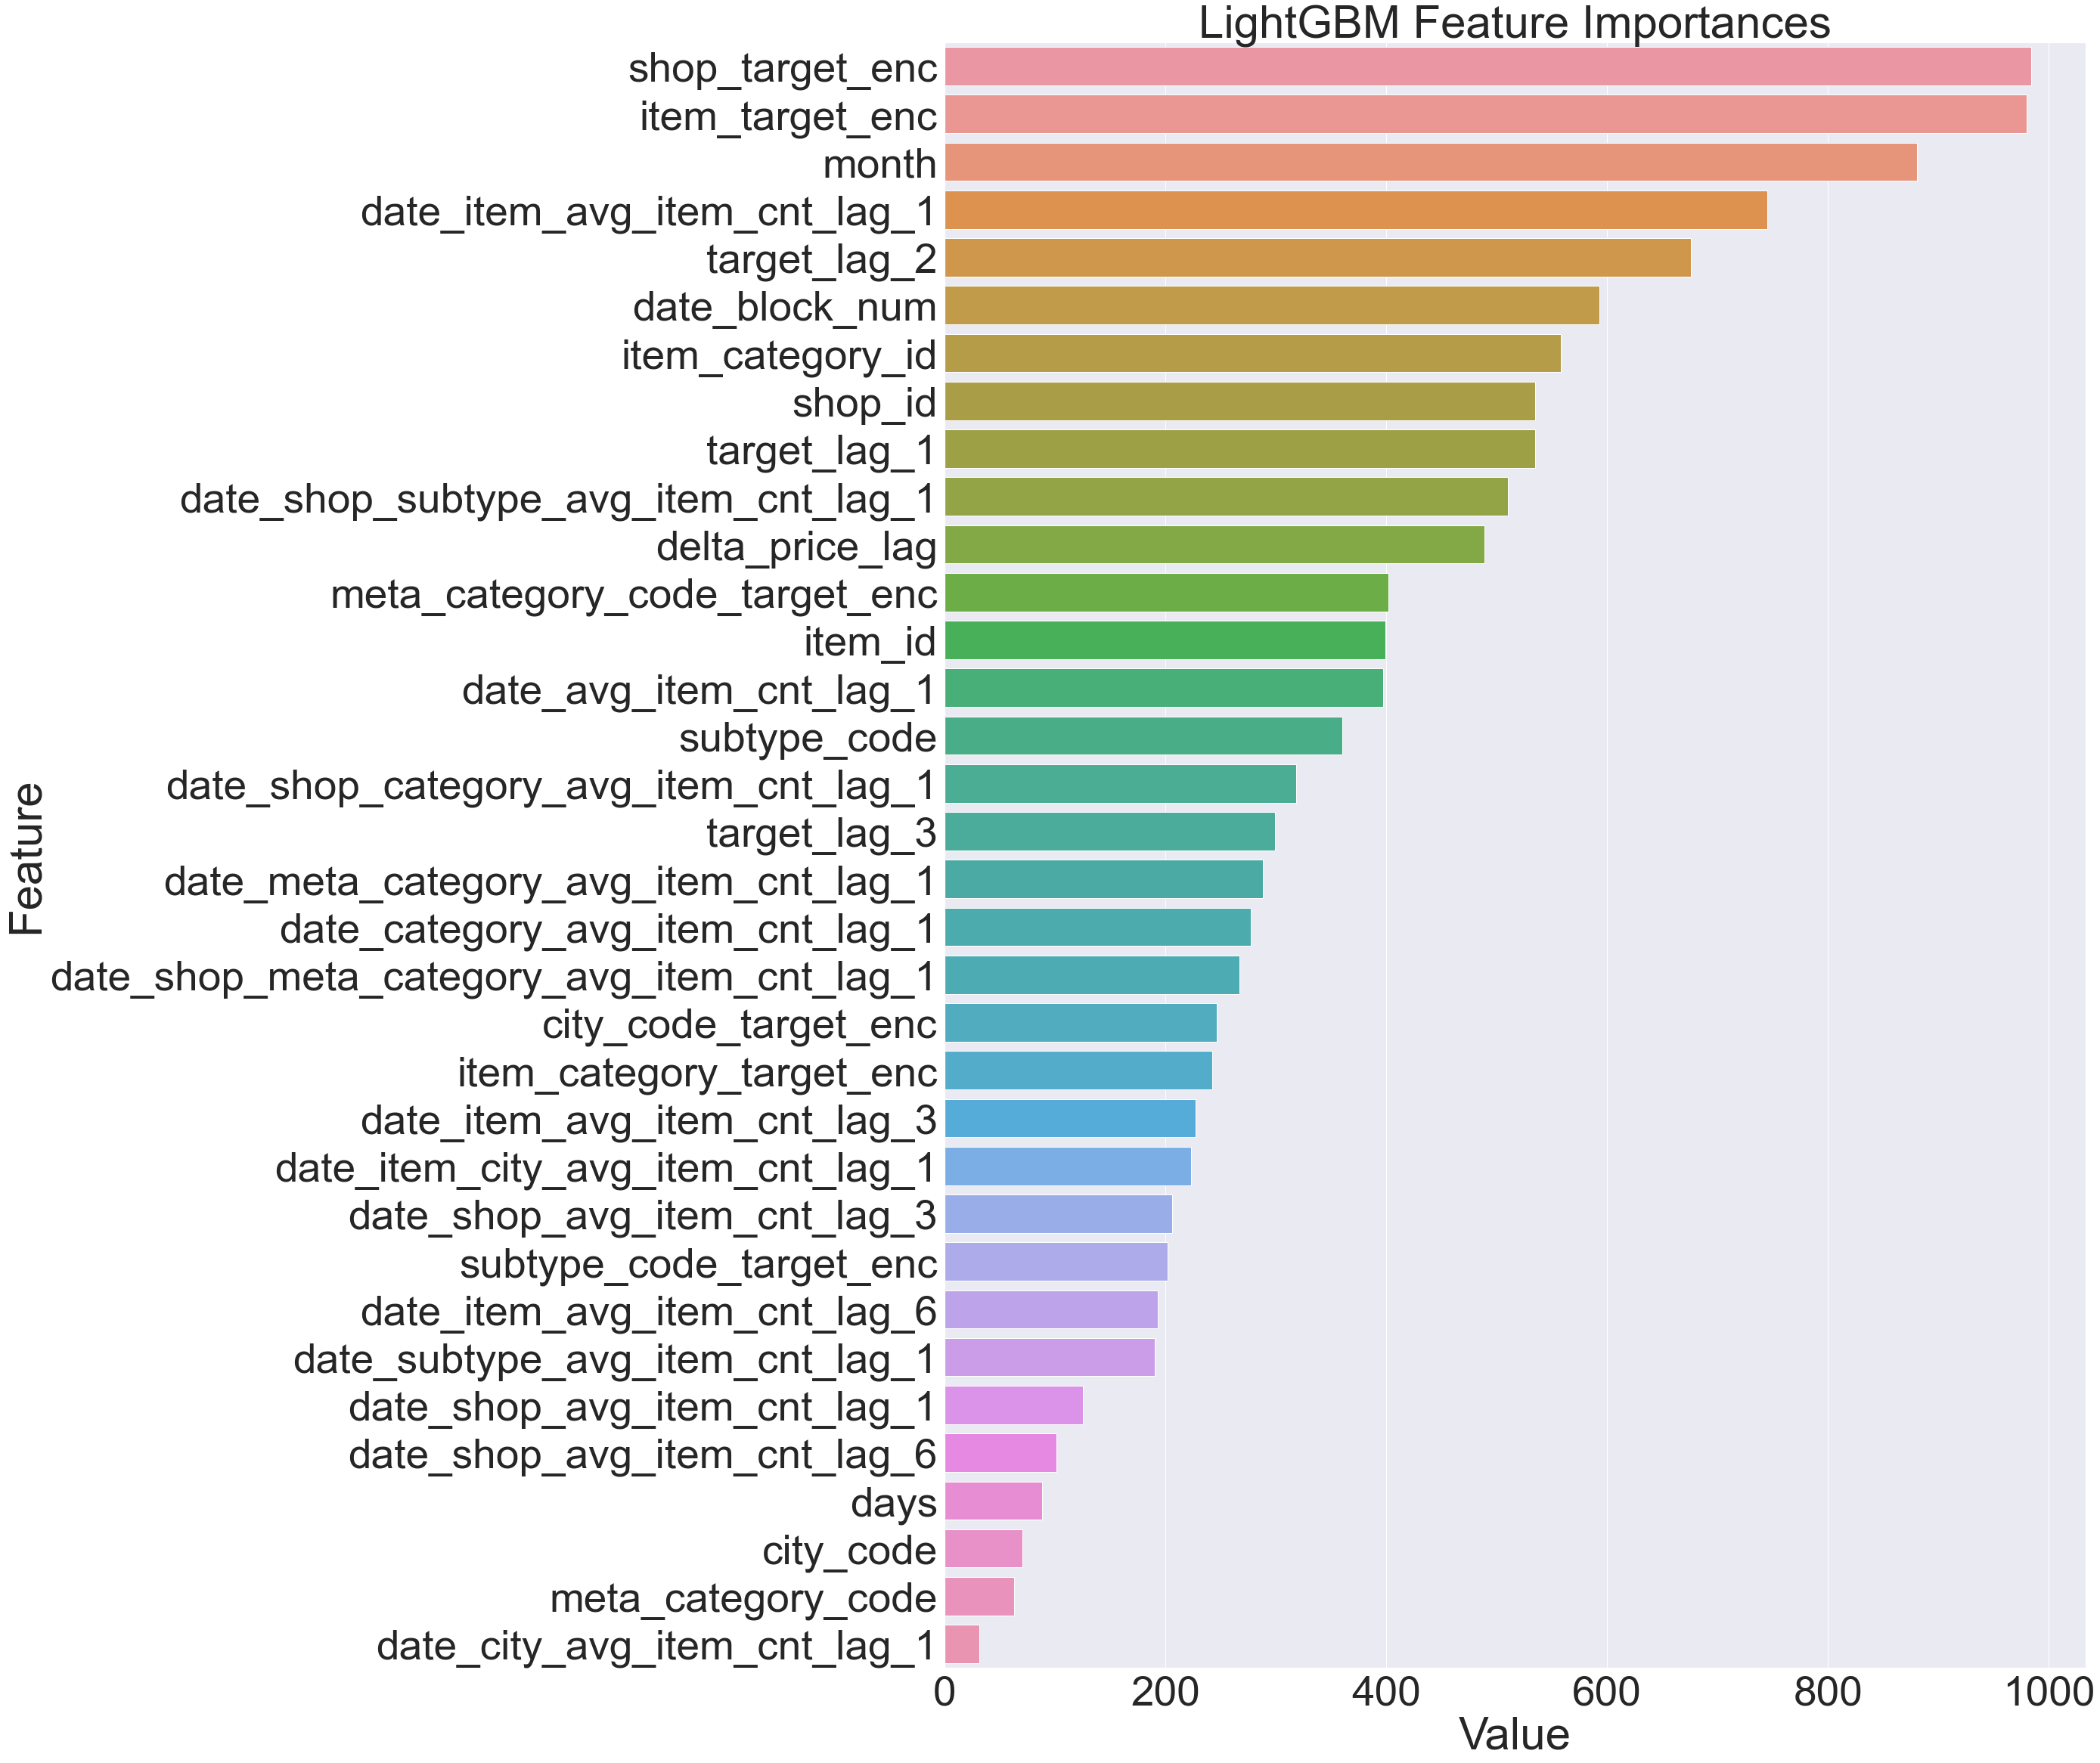

In [112]:
# Feature importances

def plotImp(model, X , num = 25, fig_size = (50, 25),importance_type='split'):
    feature_imp = pd.DataFrame({'Value':model.feature_importance(importance_type=importance_type),'Feature':X.columns})
    plt.figure(figsize=fig_size)
    sns.set(font_scale = 5)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('LightGBM Feature Importances')
    plt.tight_layout()
    plt.show()
    
plotImp(model, X_train, num = X_train.shape[1], fig_size = (40, X_train.shape[1]),importance_type='split')

#### LightGBM Hyperparameter Tuning

In [113]:
%%time
model = LGBMRegressor()
 
gridParams = {
    'learning_rate': [0.005, 0.1],
    'num_leaves': [50,2**7],
    'reg_alpha' : [1,1.2],
    'reg_lambda' : [1,1.2],
    'feature_fraction': [0.75],
    'min_data_in_leaf': [2**7],
    'bagging_fraction': [0.75],
    'num_leaves': [2**7],
    'reg_alpha': [1.0],
    'reg_lambda': [1.0],
    'bagging_freq':[1],
}
 
# Create the grid
grid = GridSearchCV(model, gridParams,
                    verbose=0,
                    cv=4,
                    n_jobs=-1)
# Run the grid
grid.fit(X_train, y_train)
 
# Print the best parameters found
print(grid.best_params_)
print(grid.best_score_)
# Using parameters already set above, replace in the best from the grid search
lgb_params['learning_rate'] = grid.best_params_['learning_rate']
lgb_params['num_leaves'] = grid.best_params_['num_leaves']
lgb_params['reg_alpha'] = grid.best_params_['reg_alpha']
lgb_params['reg_lambda'] = grid.best_params_['reg_lambda']
 
print('Fitting with params: ')
print(lgb_params)
 
model = lgb.train(lgb_params, lgb.Dataset(X_train, label=y_train), 100)

[LightGBM] [Warning] min_data_in_leaf is set=128, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=128
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
{'bagging_fraction': 0.75, 'bagging_freq': 1, 'feature_fraction': 0.75, 'learning_rate': 0.1, 'min_data_in_leaf': 128, 'num_leaves': 128, 'reg_alpha': 1.0, 'reg_lambda': 1.0}
0.559918839890477
Fitting with params: 
{'metric': 'rmse', 'objective': 'mse', 'nthread': -1, 'bagging_seed': 123, 'feature_fraction': 0.75, 'min_data_in_leaf': 128, 'bagging_fraction': 0.75, 'learning_rate': 0.1, 'num_leaves': 128, 'reg_alpha': 1.0, 'reg_lambda': 1.0, 'bagging_freq': 1, 'verbose': 0}
[LightGBM] [Warning] Auto-choosing row-wise m

In [114]:
%%time
y_pred = model.predict(X_val).clip(0, 20)
print('y_pred shape is:', y_pred.shape)

# Basic RMSE
print('The rmse of prediction is:', round(mean_squared_error(y_pred, y_val) ** 0.5, 5))

# save predictions for an ensemble
pickle.dump(y_pred, open('lgb_val.pickle', 'wb'))

y_pred shape is: (238172,)
The rmse of prediction is: 0.84731
CPU times: user 5.15 s, sys: 1.06 s, total: 6.21 s
Wall time: 1.18 s


In [115]:
%%time
y_test = model.predict(X_test).clip(0, 20)
print('y_test shape is:', y_test.shape)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": y_test
})
submission.to_csv('Final_Project_lightGBM_submission_v4.csv', index=False)

# save predictions for submission
pickle.dump(y_test, open('lgb_test.pickle', 'wb'))

y_test shape is: (214200,)
CPU times: user 5.23 s, sys: 979 ms, total: 6.21 s
Wall time: 1.85 s


## Ensemble models 

You need to implement a basic stacking scheme. We have a time component here, so we will use ***scheme f)*** from the reading material. Recall, that we always use first level models to build two datasets: test meta-features and 2-nd level train-metafetures. Let's see how we get test meta-features first. 

#### Loab First Level L1 Models

#### Loab First Level L1 Prediciation Results for Validation Sets

In [116]:
pred_valid_lr = pd.read_pickle('linear_val.pickle')
print("lr Data Validation input shape {}".format(pred_valid_lr.shape))
pred_valid_lgb = pd.read_pickle('lgb_val.pickle')
print("lgb Data Validation Columns {}".format(pred_valid_lgb.shape))

lr Data Validation input shape (238172,)
lgb Data Validation Columns (238172,)


In [117]:
pred_test_lr = pd.read_pickle('linear_test.pickle')
print("lr Data Test input shape {}".format(pred_test_lr.shape))
pred_test_lgb = pd.read_pickle('lgb_test.pickle')
print("lgb Data Test input shape {}".format(pred_test_lgb.shape))

lr Data Test input shape (214200,)
lgb Data Test input shape (214200,)


### Test meta-features

In [118]:
col = ['lr', 'lgb']
X_train_level2 = np.c_[pred_valid_lr, pred_valid_lgb]
print("X_train_level2 input shape {}".format(X_train_level2.shape))
y_train_level2 = y_val
print("y_train_level2 input shape {}".format(y_train_level2.shape))

X_test_level2 = np.c_[pred_test_lr, pred_test_lgb]
print("X_test_level2 input shape {}".format(X_test_level2.shape))

X_train_level2 input shape (238172, 2)
y_train_level2 input shape (238172,)
X_test_level2 input shape (214200, 2)


### Train meta-features

Remember, the ensembles work best, when first level models are diverse. We can qualitatively analyze the diversity by examinig *scatter plot* between the two metafeatures. Plot the scatter plot below. 

(238172, 2)
X_train_level2 Data input shape (238172, 2)


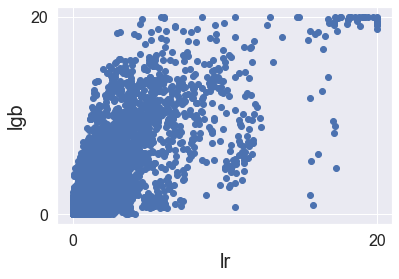

index 2 is out of bounds for axis 1 with size 2.


In [119]:
import matplotlib.pyplot as plt
print(X_train_level2.shape)
print("X_train_level2 Data input shape {}".format(X_train_level2.shape))
for i in range(X_train_level2.shape[1]):
    try:
        plt.scatter(X_train_level2[:, i], X_train_level2[:, i+1])
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        plt.xlabel(col[i], fontsize=20)
        plt.ylabel(col[i+1], fontsize=20)
        plt.show()
    except IndexError:  
        print ("index 2 is out of bounds for axis 1 with size 2." )

## Ensemble 1st Level Models

Now, when the meta-features are created, we can ensemble our first level models.

### Stacking

Now, we will try a more advanced ensembling technique. Fit a linear regression model to the meta-features. Use the same parameters as in the model above.

In [120]:
meta_model = Ridge()
meta_model.fit(X_train_level2, y_train_level2)

Ridge()

Compute RMSE and R-squared on the train sets.

In [121]:
train_preds = meta_model.predict(X_train_level2).clip(0, 20)
# R^2
r2_train_stacking = r2_score(y_train_level2, train_preds)
print('Train R-squared for stacking is %f' % r2_train_stacking)

# Basic RMSE
print('The rmse of prediction is:', round(mean_squared_error(train_preds, y_train_level2) ** 0.5, 5))

Train R-squared for stacking is 0.450405
The rmse of prediction is: 0.84228


In [122]:
%%time
test_preds = meta_model.predict(X_test_level2).clip(0, 20)

print('test_preds shape is:', test_preds.shape)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": test_preds
})
submission.to_csv('Final_Project_Ensemble_submission_v4.csv', index=False)

# save predictions for submission
pickle.dump(test_preds, open('ensemble_test.pickle', 'wb'))

test_preds shape is: (214200,)
CPU times: user 1.16 s, sys: 133 ms, total: 1.3 s
Wall time: 855 ms


In [123]:
print('It takes %s minutes' % ((time.time() - start_0)/60))

It takes 17.407930823167167 minutes
